In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout,TimeDistributed,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

In [5]:
# โหลดข้อมูล
df = pd.read_csv("C:\\Users\\HP\\Desktop\\LSTM\model Temp\\LSTM\\Sleep testFiltered_EEG_Data1.csv")

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\HP\AppData\Local\Temp\ipykernel_3856\876263972.py:2: SyntaxWarning: invalid escape sequence '\m'
  df = pd.read_csv("C:\\Users\\HP\\Desktop\\LSTM\model Temp\\LSTM\\Sleep testFiltered_EEG_Data1.csv")


In [6]:
channel_map = {
    "1": "EEG F4-M1",
    "2": "EEG C4-M1",
    "3": "EEG O2-M1",
    "4": "EEG C3-M2",
    "5": "EMG chin",
    "6": "EOG E1-M2",
    "7": "EOG E2-M2",
    "8": "ECG"
}
# เปลี่ยนชื่อ column ใน DataFrame
df = df.rename(columns=channel_map)

# ตรวจสอบ
print(df.head())

       Time  EEG F4-M1  EEG C4-M1  EEG O2-M1  EEG C3-M2  EMG chin  EOG E1-M2  \
0  0.000000  -0.332139   1.460207  -0.082405   0.945965 -0.556532   8.282122   
1  0.003906   0.455678  -0.506964  -8.182390   2.241613  3.137224  18.753385   
2  0.007812  -0.995135  -3.805043 -15.517629   2.785924  5.121238  26.958536   
3  0.011719  -5.017469  -7.255061 -18.758616   1.417463  5.081020  29.945681   
4  0.015625 -10.258652  -9.017413 -16.288979  -2.295541  4.092776  27.027844   

   EOG E2-M2        ECG      Annotation  
0  -6.846270 -36.322502   Sleep stage W  
1  -6.397049 -36.334116   Sleep stage W  
2  -7.204251 -37.603388   Sleep stage W  
3  -9.951360 -42.065282   Sleep stage W  
4 -13.573874 -50.681696   Sleep stage W  


In [7]:
data = df.drop(['Annotation','Time'], axis=1)
labels = df['Annotation']

In [8]:
N2,W,R,N1,N3=labels.value_counts()
print(N2+W+R+N1+N3)
print(labels.value_counts())

6558720
Annotation
Sleep stage N2    3302400
Sleep stage W     1159680
Sleep stage R     1082880
Sleep stage N1     837120
Sleep stage N3     176640
Name: count, dtype: int64


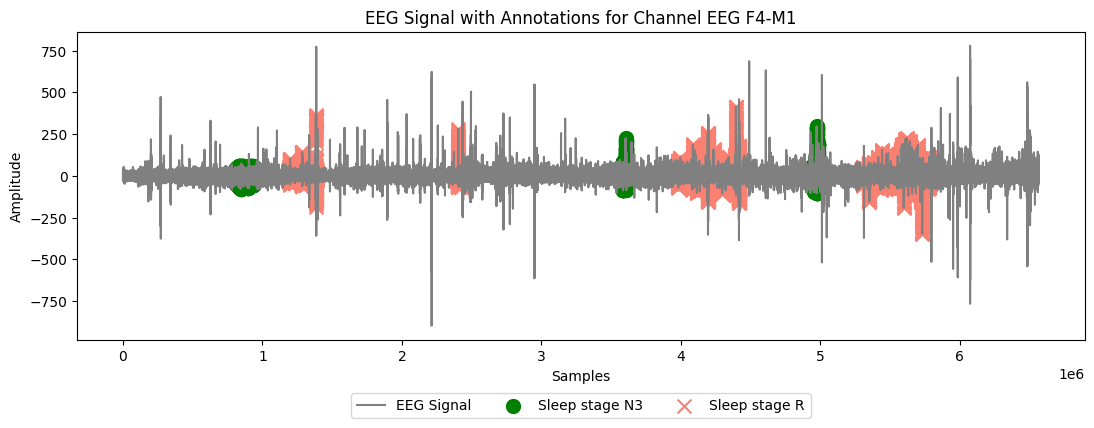

In [9]:
plt.figure(figsize=(13, 4))
plt.plot(df.index, df['EEG F4-M1'], c = 'gray',label='EEG Signal')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage N3'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage N3'], c = 'green', label='Sleep stage N3', s=100, marker='o')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage R'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage R'], c = 'salmon', label='Sleep stage R', s=100, marker='x')

plt.title("EEG Signal with Annotations for Channel EEG F4-M1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

plt.show()

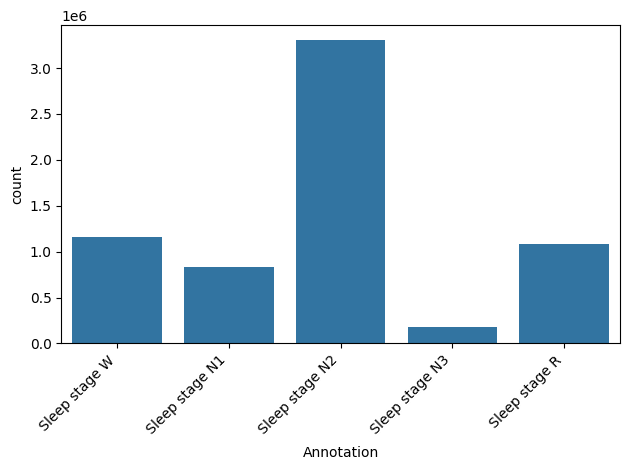

The number of Sleep stage Wake is: 1159680
The number of Sleep stage N1 is: 837120
The number of Sleep stage N2 is: 3302400
The number of Sleep stage N3 is: 176640
The number of Sleep stage N4 is: 1082880


(np.float64(-1.099999935444984),
 np.float64(1.100000012416193),
 np.float64(-1.0999999580006097),
 np.float64(1.099999998000029))

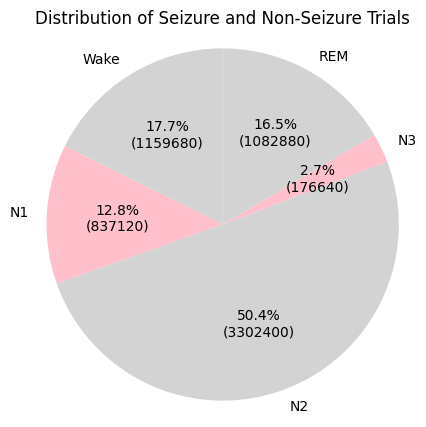

In [10]:
# Assuming 'labels' is a Series or list containing your label data
sns.countplot(x=labels)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate the number of non-seizure and seizure trials
N2,W,R,N1,N3 = labels.value_counts()

# Print the counts
print('The number of Sleep stage Wake is:', W)
print('The number of Sleep stage N1 is:', N1)
print('The number of Sleep stage N2 is:', N2)
print('The number of Sleep stage N3 is:', N3)
print('The number of Sleep stage N4 is:', R)
# Create a pie chart with percentage and number of samples
labels_counts = [W,N1,N2,N3,R]
labels_names = ['Wake','N1','N2','N3','REM']

def autopct_format(values):
    def my_format(pct):
        total = sum(values)
        absolute = int(round(pct/100.*total))
        return f"{pct:.1f}%\n({absolute})"
    return my_format

plt.figure(figsize=(5, 5))
plt.pie(labels_counts, labels=labels_names, autopct=autopct_format(labels_counts), startangle=90, colors=['lightgrey', 'pink'])
plt.title('Distribution of Seizure and Non-Seizure Trials')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Display the pie chart

### Split data

In [16]:
# ---- Define split ranges ----
train_start, train_end = 0.12, 0.25
test_start, test_end = 0.50, 0.75
val_start, val_end = 0.75, 1.00

n = len(data)

# ---- Convert to index positions ----
train_idx = slice(int(n * train_start), int(n * train_end))
test_idx = slice(int(n * test_start), int(n * test_end))
val_idx = slice(int(n * val_start), int(n * val_end))

# ---- Split datasets ----
X_train_df = data[train_idx]
y_train_df = labels[train_idx]

X_test_df = data[test_idx]
y_test_df = labels[test_idx]

X_val_df = data[val_idx]
y_val_df = labels[val_idx]

# ---- Check class proportion ----
print("Train class distribution (%):")
print(y_train_df.value_counts(normalize=True) * 100)

print("\nTest class distribution (%):")
print(y_test_df.value_counts(normalize=True) * 100)

print("\nValidation class distribution (%):")
print(y_val_df.value_counts(normalize=True) * 100)



Train class distribution (%):
Annotation
Sleep stage N2    45.119208
Sleep stage R     21.592443
Sleep stage N3    11.695906
Sleep stage N1    10.796221
Sleep stage W     10.796221
Name: proportion, dtype: float64

Test class distribution (%):
Annotation
Sleep stage N2    61.169591
Sleep stage R     26.198830
Sleep stage N1     7.953216
Sleep stage N3     2.339181
Sleep stage W      2.339181
Name: proportion, dtype: float64

Validation class distribution (%):
Annotation
Sleep stage N2    43.595770
Sleep stage R     27.732080
Sleep stage W     15.511163
Sleep stage N1    10.810811
Sleep stage N3     2.350176
Name: proportion, dtype: float64


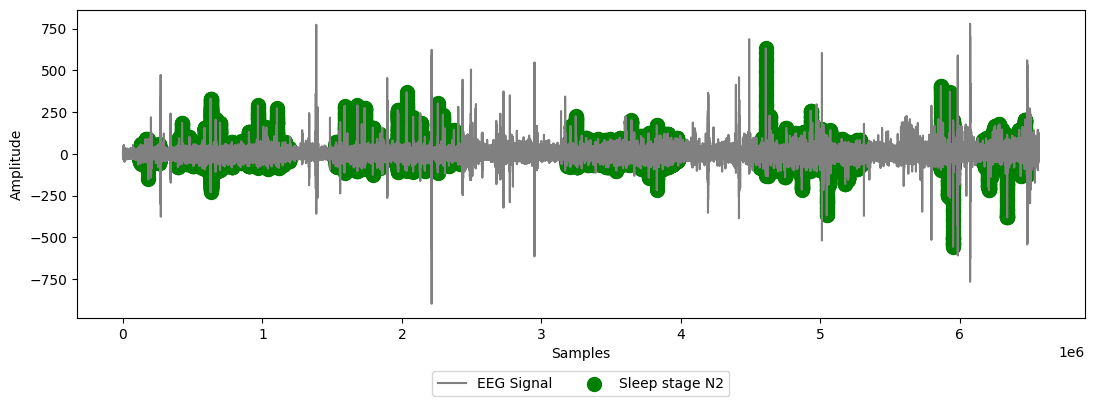

In [227]:
plt.figure(figsize=(13, 4))
plt.plot(df.index, df['EEG F4-M1'], c = 'gray',label='EEG Signal')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage N2'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage N2'], c = 'green', label='Sleep stage N2', s=100, marker='o')

plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

plt.show()

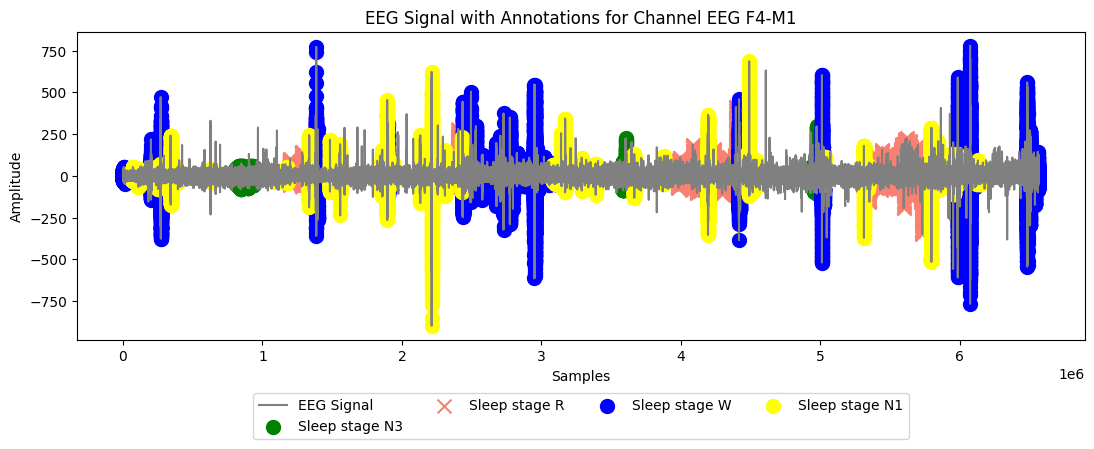

In [166]:
plt.figure(figsize=(13, 4))
plt.plot(df.index, df['EEG F4-M1'], c = 'gray',label='EEG Signal')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage N3'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage N3'], c = 'green', label='Sleep stage N3', s=100, marker='o')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage R'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage R'], c = 'salmon', label='Sleep stage R', s=100, marker='x')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage W'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage W'], c = 'blue', label='Sleep stage W', s=100, marker='o')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage N1'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage N1'], c = 'yellow', label='Sleep stage N1', s=100, marker='o')
plt.title("EEG Signal with Annotations for Channel EEG F4-M1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

plt.show()

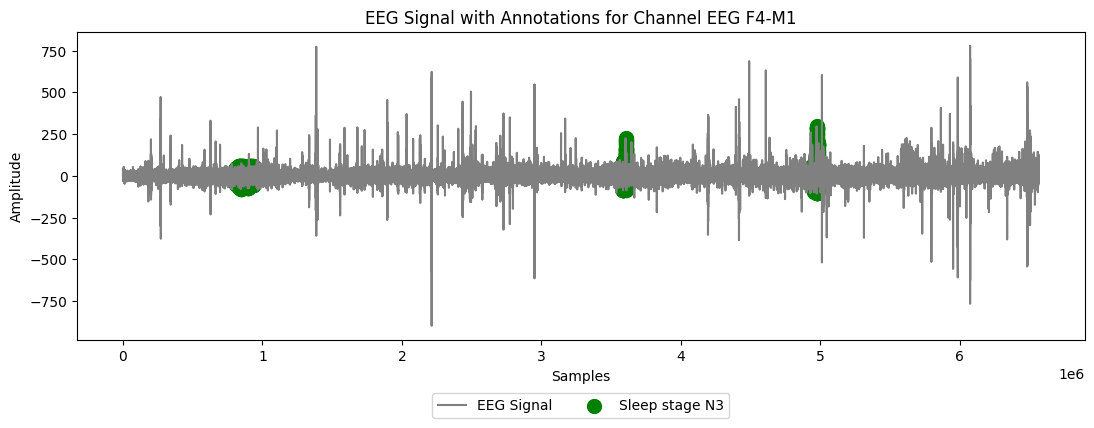

In [11]:
plt.figure(figsize=(13, 4))
plt.plot(df.index, df['EEG F4-M1'], c = 'gray',label='EEG Signal')
plt.scatter(df.index[df['Annotation'] == ' Sleep stage N3'], df['EEG F4-M1'][df['Annotation'] == ' Sleep stage N3'], c = 'green', label='Sleep stage N3', s=100, marker='o')

plt.title("EEG Signal with Annotations for Channel EEG F4-M1")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.show()

plt.show()

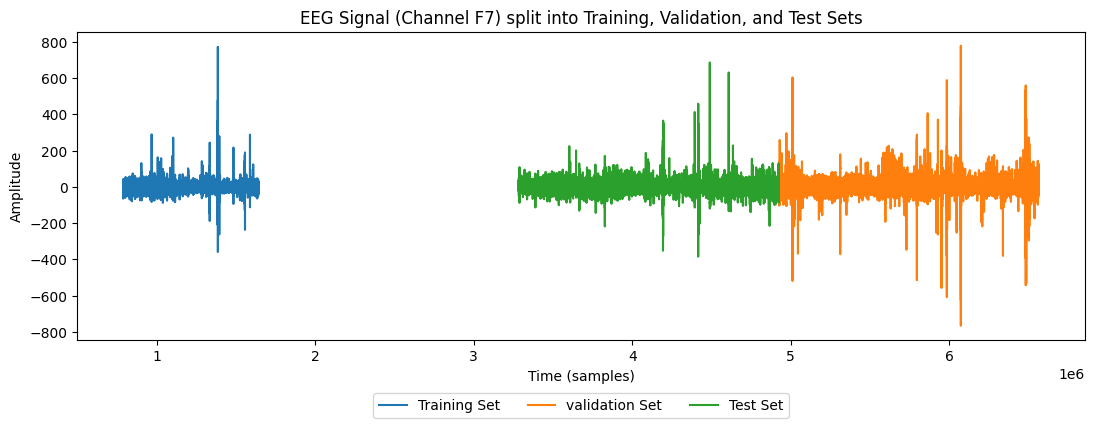

In [187]:
plt.figure(figsize=(13, 4))
plt.plot(X_train_df['EEG F4-M1'], label='Training Set')
plt.plot(X_val_df['EEG F4-M1'], label='validation Set')
plt.plot(X_test_df['EEG F4-M1'], label='Test Set')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.title("EEG Signal (Channel F7) split into Training, Validation, and Test Sets")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

plt.show()

In [56]:
y_train_df.value_counts(), y_val_df.value_counts(), y_test_df.value_counts()

(Annotation
 Sleep stage N2    385152
 Sleep stage R     184320
 Sleep stage N3     99840
 Sleep stage N1     92160
 Sleep stage W      92160
 Name: count, dtype: int64,
 Annotation
 Sleep stage R     453120
 Sleep stage N2    355200
 Sleep stage N1    107520
 Sleep stage N3     38400
 Sleep stage W      30720
 Name: count, dtype: int64,
 Annotation
 Sleep stage N2    1004160
 Sleep stage R      430080
 Sleep stage N1     130560
 Sleep stage N3      38400
 Sleep stage W       38400
 Name: count, dtype: int64)

### Oversampling

smt = SMOTE(sampling_strategy='minority', random_state=42, k_neighbors=5)
X_train_df, y_train_df = smt.fit_resample(X_train_df, y_train_df)

print(y_train_df.value_counts())
print(y_val_df.value_counts())
print(y_test_df.value_counts())

X_train_df.shape, X_val_df.shape, X_test_df.shape

plt.figure(figsize=(13,4))
plt.plot(X_train_df['EEG F4-M1'], color='salmon', label='Trainning Set')
plt.legend()
plt.title('Oversample the training data')
plt.show()

### Select Channel

In [188]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853632 entries, 787968 to 1641599
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   EEG F4-M1  853632 non-null  float64
 1   EEG C4-M1  853632 non-null  float64
 2   EEG O2-M1  853632 non-null  float64
 3   EEG C3-M2  853632 non-null  float64
 4   EMG chin   853632 non-null  float64
 5   EOG E1-M2  853632 non-null  float64
 6   EOG E2-M2  853632 non-null  float64
 7   ECG        853632 non-null  float64
dtypes: float64(8)
memory usage: 52.1 MB


In [189]:
selected_channels = ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1','EEG C3-M2']

# Create the new DataFrame with only the selected channels
X_train_df_reduced = X_train_df[selected_channels]
X_val_df_reduced = X_val_df[selected_channels]
X_test_df_reduced = X_test_df[selected_channels]

X_train_df_reduced.shape, X_val_df_reduced.shape, X_test_df_reduced.shape

((853632, 4), (1641600, 4), (1641600, 4))

### Create Sliding Window

In [190]:
def apply_sliding_window(data, label, window_size, step_size):
    # Reset index เพื่อให้ iloc ทำงานได้แน่นอน
    data = data.reset_index(drop=True)
    label = label.reset_index(drop=True)

    window_data = []
    window_label = []

    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i:i + window_size]
        label_slice = label.iloc[i:i + window_size]

        # ตรวจว่าทั้ง window มี label เดียวกันไหม
        unique_labels = label_slice.unique()
        if len(unique_labels) == 1:  # ✅ มีคลาสเดียว
            window_data.append(window)
            window_label.append(unique_labels[0])
        else:
            continue  # 🚫 ถ้ามีมากกว่า 1 คลาส -> ข้ามเลย

    X = np.array(window_data)
    y = np.array(window_label)
    return X, y



In [206]:
# Define parameters
window_size = 256
step_size = 128

# Apply sliding window function to the train/test set
X_train, y_train =  apply_sliding_window(X_train_df, y_train_df, window_size, step_size)
X_val, y_val =  apply_sliding_window(X_val_df, y_val_df, window_size, step_size)
X_test, y_test = apply_sliding_window(X_test_df, y_test_df, window_size, step_size)

X_train_reduced, y_train_reduced =  apply_sliding_window(X_train_df_reduced, y_train_df, window_size, step_size)
X_val_reduced, y_val_reduced =  apply_sliding_window(X_val_df_reduced, y_val_df, window_size, step_size)
X_test_reduced, y_test_reduced = apply_sliding_window(X_test_df_reduced, y_test_df, window_size, step_size)

print("X_train:" ,X_train.shape, ", y_train:", y_train.shape)
print("X_val:" ,X_val.shape, ", y_val:", y_val.shape)
print("X_test:" ,X_test.shape, ", y_test:", y_test.shape)

print("X_train_reduced:" ,X_train_reduced.shape, ", y_train_reduced:", y_train_reduced.shape)
print("X_val_reduced:" ,X_val_reduced.shape, ", y_val_reduced:", y_val_reduced.shape)
print("X_test_reduced:" ,X_test_reduced.shape, ", y_test_reduced:", y_test_reduced.shape)

X_train: (6644, 256, 8) , y_train: (6644,)
X_val: (12800, 256, 8) , y_val: (12800,)
X_test: (12808, 256, 8) , y_test: (12808,)
X_train_reduced: (6644, 256, 4) , y_train_reduced: (6644,)
X_val_reduced: (12800, 256, 4) , y_val_reduced: (12800,)
X_test_reduced: (12808, 256, 4) , y_test_reduced: (12808,)


Sample (original y_train_df):
Annotation
Sleep stage N2    385152
Sleep stage R     184320
Sleep stage N3     99840
Sleep stage N1     92160
Sleep stage W      92160
Name: count, dtype: int64
After Sliding Window (selected channels y_train_reduced):
Sleep stage N2    2998
Sleep stage R     1438
Sleep stage N3     775
Sleep stage W      719
Sleep stage N1     714
Name: count, dtype: int64
                N Sample
Annotation              
Sleep stage N2    385152
Sleep stage R     184320
Sleep stage N3     99840
Sleep stage N1     92160
Sleep stage W      92160


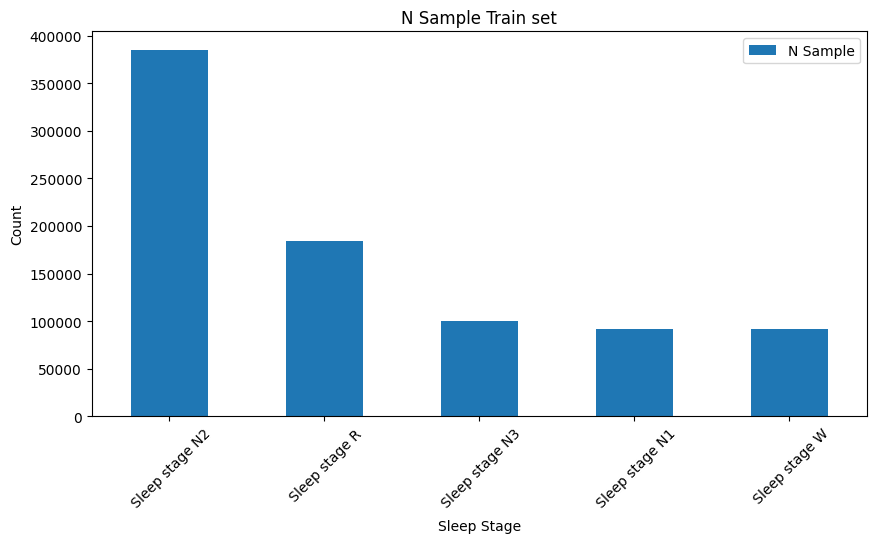

Annotation
Sleep stage N2    45.119208
Sleep stage R     21.592443
Sleep stage N3    11.695906
Sleep stage N1    10.796221
Sleep stage W     10.796221
Name: proportion, dtype: float64


In [192]:
print("Sample (original y_train_df):")
print(y_train_df.value_counts())
print("After Sliding Window (selected channels y_train_reduced):")
print(pd.Series(y_train_reduced).value_counts())
# รวมผลเป็น DataFrame เพื่อเทียบง่าย ๆ
annotation_check = pd.DataFrame({
    "N Sample": y_train_df.value_counts(),
}).fillna(0).astype(int)

print(annotation_check)
annotation_check.plot(kind="bar", figsize=(10, 5))
plt.title("N Sample Train set")
plt.ylabel("Count")
plt.xlabel("Sleep Stage")
plt.xticks(rotation=45)
plt.show()
print(y_train_df.value_counts(normalize=True) * 100)

In [207]:
def clean_X_y(X, y):
    """Remove samples where y is NaN or 'nan' string"""
    # ตัดให้ X, y มีความยาวเท่ากันก่อน
    min_len = min(len(X), len(y))
    X = X[:min_len]
    y = y[:min_len]

    mask = ~(pd.isna(y) | (y == 'nan'))
    X_clean = X[mask]
    y_clean = y[mask]
    return X_clean, y_clean

# --- ลบ NaN และทำให้ขนาดตรงกัน ---
X_train, y_train = clean_X_y(X_train, y_train)
X_val, y_val     = clean_X_y(X_val, y_val)
X_test, y_test   = clean_X_y(X_test, y_test)

print("Shapes after cleaning NaN:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Shapes after cleaning NaN:
X_train: (6644, 256, 8) y_train: (6644,)
X_val: (12741, 256, 8) y_val: (12741,)
X_test: (12808, 256, 8) y_test: (12808,)


## Train

### CNN

In [175]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight

In [208]:

# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32 และ shape = (samples, timesteps, features)
# -----------------------------
X_train = np.array(X_train_reduced, dtype=np.float32)
X_val   = np.array(X_val_reduced, dtype=np.float32)
X_test  = np.array(X_test_reduced, dtype=np.float32)

if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)  # (samples, timesteps, channels)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง CNN model
# -----------------------------
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

X_train shape: (6644, 256, 4)
y_train shape: (6644, 5)


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)              │ (None, 250, 32)        │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 250, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (None, 121, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 121, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_34 (Conv1D)              │ (None, 58, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 58, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_34 (MaxPooling1D) │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_35 (Conv1D)              │ (None, 25, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,189 (692.14 KB)

 Trainable params: 176,613 (689.89 KB)

 Non-trainable params: 576 (2.25 KB)

In [211]:
# --- Ensure all sets are same length ---
min_train_len = min(len(X_train), len(y_train_cat))
min_val_len   = min(len(X_val), len(y_val_cat))
min_test_len  = min(len(X_test), len(y_test_cat))

X_train = X_train[:min_train_len]
y_train_cat = y_train_cat[:min_train_len]

X_val = X_val[:min_val_len]
y_val_cat = y_val_cat[:min_val_len]

X_test = X_test[:min_test_len]
y_test_cat = y_test_cat[:min_test_len]

print("After sync:")
print("Train:", X_train.shape, y_train_cat.shape)
print("Val:  ", X_val.shape, y_val_cat.shape)
print("Test: ", X_test.shape, y_test_cat.shape)

After sync:
Train: (6644, 256, 4) (6644, 5)
Val:   (12741, 256, 4) (12741, 5)
Test:  (12808, 256, 4) (12808, 5)


In [212]:
# -----------------------------
# 4. Train CNN model (no early stopping)
# -----------------------------
callbacks = [
    ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True)
]

history = model_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=80,
    batch_size=32,
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5902 - loss: 0.9574 - val_accuracy: 0.4156 - val_loss: 1.8418
Epoch 2/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6337 - loss: 0.8626 - val_accuracy: 0.3855 - val_loss: 2.6925
Epoch 3/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6537 - loss: 0.8056 - val_accuracy: 0.3044 - val_loss: 3.0500
Epoch 4/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6928 - loss: 0.7395 - val_accuracy: 0.2677 - val_loss: 4.4758
Epoch 5/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7280 - loss: 0.6674 - val_accuracy: 0.3497 - val_loss: 5.7581
Epoch 6/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7587 - loss: 0.5942 - val_accuracy: 0.4353 - val_loss: 5.0896
Epoch 7/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7772 - loss: 0.5385 - val_accuracy: 0.4416 - val_loss: 8.9212
Epoch 8/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8082 - loss: 0.4874 - val_accu

In [213]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model_cnn.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3791 - loss: 18.8221
Test Loss: 18.8221, Test Accuracy: 37.91%


In [214]:
threshold = 0.5  # set the threshold value
y_pred_prob = model_cnn.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


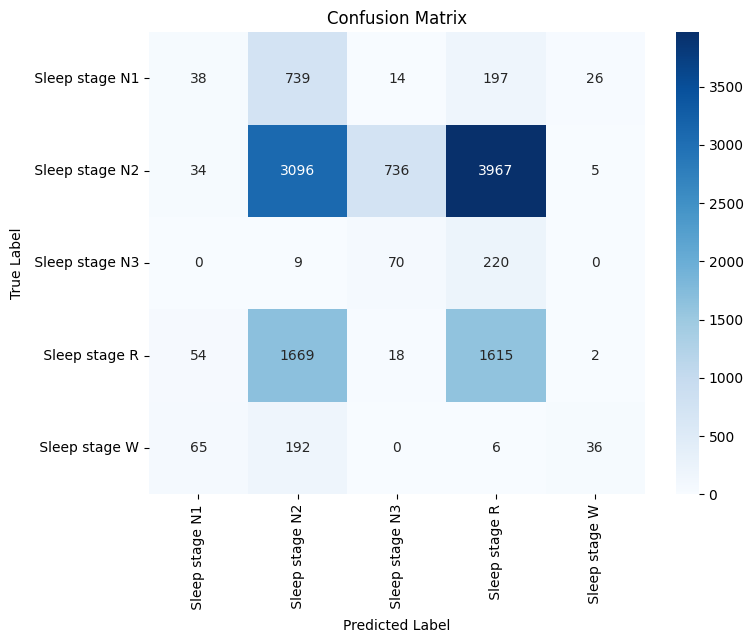

                 precision    recall  f1-score   support

 Sleep stage N1       0.20      0.04      0.06      1014
 Sleep stage N2       0.54      0.39      0.46      7838
 Sleep stage N3       0.08      0.23      0.12       299
  Sleep stage R       0.27      0.48      0.34      3358
  Sleep stage W       0.52      0.12      0.20       299

       accuracy                           0.38     12808
      macro avg       0.32      0.25      0.24     12808
   weighted avg       0.43      0.38      0.38     12808



In [215]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model_cnn.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))

In [223]:
pd.Series(y_val).value_counts()


Sleep stage N2    5558
Sleep stage R     3538
Sleep stage W     1975
Sleep stage N1    1372
Sleep stage N3     298
Name: count, dtype: int64

## ลองทำ CNN+Class weight

In [217]:
# -----------------------------
# 1. Encode labels
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. Compute class weights
# -----------------------------
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

# -----------------------------
# 3. CNN model
# -----------------------------
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
model_cnn.summary()

Class Weights: {0: np.float64(1.8610644257703082), 1: np.float64(0.44322881921280854), 2: np.float64(1.7145806451612904), 3: np.float64(0.9240611961057024), 4: np.float64(1.8481223922114047)}


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)              │ (None, 250, 32)        │           928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 250, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 125, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 121, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 121, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 58, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 58, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 25, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 25, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 177,189 (692.14 KB)

 Trainable params: 176,613 (689.89 KB)

 Non-trainable params: 576 (2.25 KB)

In [218]:
# --- Ensure all sets are same length ---
min_train_len = min(len(X_train), len(y_train_cat))
min_val_len   = min(len(X_val), len(y_val_cat))
min_test_len  = min(len(X_test), len(y_test_cat))

X_train = X_train[:min_train_len]
y_train_cat = y_train_cat[:min_train_len]

X_val = X_val[:min_val_len]
y_val_cat = y_val_cat[:min_val_len]

X_test = X_test[:min_test_len]
y_test_cat = y_test_cat[:min_test_len]

print("After sync:")
print("Train:", X_train.shape, y_train_cat.shape)
print("Val:  ", X_val.shape, y_val_cat.shape)
print("Test: ", X_test.shape, y_test_cat.shape)

After sync:
Train: (6644, 256, 4) (6644, 5)
Val:   (12741, 256, 4) (12741, 5)
Test:  (12808, 256, 4) (12808, 5)


In [219]:
# -----------------------------
# 4. Train CNN model
# -----------------------------
history = model_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=80,
    batch_size=32,
    shuffle=True,
)

Epoch 1/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4744 - loss: 1.3463 - val_accuracy: 0.4307 - val_loss: 1.7726
Epoch 2/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5774 - loss: 0.9638 - val_accuracy: 0.4365 - val_loss: 2.0033
Epoch 3/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6138 - loss: 0.8849 - val_accuracy: 0.4683 - val_loss: 2.1520
Epoch 4/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6535 - loss: 0.8101 - val_accuracy: 0.3840 - val_loss: 2.7015
Epoch 5/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6836 - loss: 0.7396 - val_accuracy: 0.3838 - val_loss: 2.8494
Epoch 6/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6969 - loss: 0.7174 - val_accuracy: 0.3346 - val_loss: 3.8772
Epoch 7/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7408 - loss: 0.6166 - val_accuracy: 0.3298 - val_loss: 5.9005
Epoch 8/80
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7631 - loss: 0.5710 - val_accu

In [220]:
# -----------------------------
# 5. Evaluate model
# -----------------------------
loss, accuracy = model_cnn.evaluate(X_test, y_test_cat)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3671 - loss: 18.7679
Test Loss: 18.7679, Test Accuracy: 36.71%


In [221]:
threshold = 0.5  # set the threshold value
y_pred_prob = model_cnn.predict(X_test)  # generate prediction probabilities
y_pred = (y_pred_prob > threshold).astype(int)

401/401 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


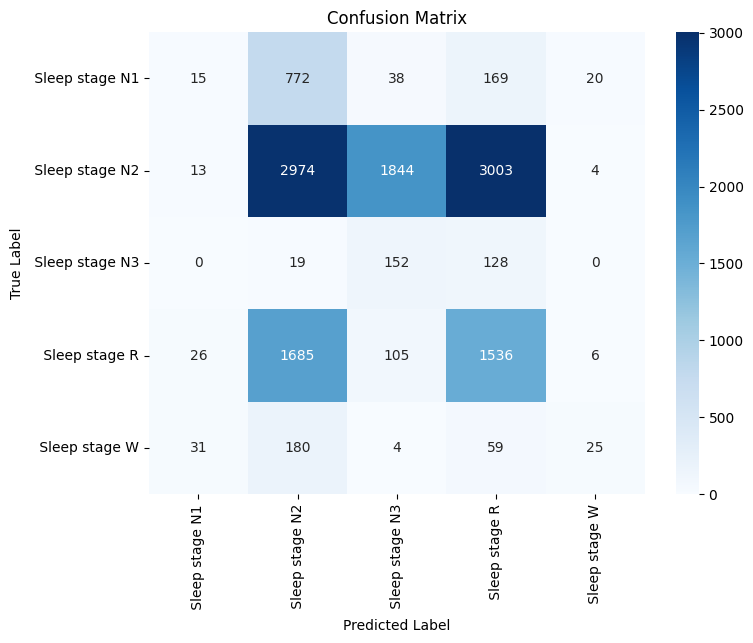

                 precision    recall  f1-score   support

 Sleep stage N1       0.18      0.01      0.03      1014
 Sleep stage N2       0.53      0.38      0.44      7838
 Sleep stage N3       0.07      0.51      0.12       299
  Sleep stage R       0.31      0.46      0.37      3358
  Sleep stage W       0.45      0.08      0.14       299

       accuracy                           0.37     12808
      macro avg       0.31      0.29      0.22     12808
   weighted avg       0.43      0.37      0.38     12808



In [222]:
# --------------------------
# 1. Predict labels
# --------------------------
y_pred_probs = model_cnn.predict(X_test)   # ได้เป็น probability (softmax)
y_pred = np.argmax(y_pred_probs, axis=1)  # แปลงเป็น class index
y_true = np.argmax(y_test_cat, axis=1)    # แปลง one-hot y_test กลับเป็น index

# --------------------------
# 2. Confusion matrix
# --------------------------
cm = confusion_matrix(y_true, y_pred)

# --------------------------
# 3. Plot confusion matrix
# --------------------------
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=encoder.classes_,
            yticklabels=encoder.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# --------------------------
# 4. (optional) Classification report
# --------------------------
print(classification_report(y_true, y_pred, target_names=encoder.classes_))